In [23]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import os
from dataclasses import dataclass
from typing import Union
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import psutil
import subprocess

#MAMBA MODEL#

In [24]:
"""

An implementation of the parallel scan operation in PyTorch (Blelloch version).
Please see docs/pscan.ipynb for a detailed explanation of what happens here.

"""

def npo2(len):
    """
    Returns the next power of 2 above len
    """

    return 2 ** math.ceil(math.log2(len))

def pad_npo2(X):
    """
    Pads input length dim to the next power of 2

    Args:
        X : (B, L, D, N)

    Returns:
        Y : (B, npo2(L), D, N)
    """

    len_npo2 = npo2(X.size(1))
    pad_tuple = (0, 0, 0, 0, 0, len_npo2 - X.size(1))
    return F.pad(X, pad_tuple, "constant", 0)

class PScan(torch.autograd.Function):
    @staticmethod
    def pscan(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # modifies X in place by doing a parallel scan.
        # more formally, X will be populated by these values :
        # H[t] = A[t] * H[t-1] + X[t] with H[0] = 0
        # which are computed in parallel (2*log2(T) sequential steps (ideally), instead of T sequential steps)

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :, 1].add_(Aa[:, :, :, 1].mul(Xa[:, :, :, 0]))
            Aa[:, :, :, 1].mul_(Aa[:, :, :, 0])

            Aa = Aa[:, :, :, 1]
            Xa = Xa[:, :, :, 1]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            Aa[:, :, 1].mul_(Aa[:, :, 0])

            Xa[:, :, 3].add_(Aa[:, :, 3].mul(Xa[:, :, 2] + Aa[:, :, 2].mul(Xa[:, :, 1])))
        elif Xa.size(2) == 2:
            Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 0]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa = X[:, :, 2**(num_steps-2)-1:L:2**(num_steps-2)]
        Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 1]))
        Aa[:, :, 2].mul_(Aa[:, :, 1])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 2**k-1:L:2**k]
            Xa = X[:, :, 2**k-1:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, 1:, 0].add_(Aa[:, :, 1:, 0].mul(Xa[:, :, :-1, 1]))
            Aa[:, :, 1:, 0].mul_(Aa[:, :, :-1, 1])

    @staticmethod
    def pscan_rev(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # the same function as above, but in reverse
        # (if you flip the input, call pscan, then flip the output, you get what this function outputs)
        # it is used in the backward pass

        # only supports L that is a power of two (mainly for a clearer code)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep (last 2 steps unfolded)
        Aa = A
        Xa = X
        for _ in range(num_steps-2):
            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :, 0].add_(Aa[:, :, :, 0].mul(Xa[:, :, :, 1]))
            Aa[:, :, :, 0].mul_(Aa[:, :, :, 1])

            Aa = Aa[:, :, :, 0]
            Xa = Xa[:, :, :, 0]

        # we have only 4, 2 or 1 nodes left
        if Xa.size(2) == 4:
            Xa[:, :, 2].add_(Aa[:, :, 2].mul(Xa[:, :, 3]))
            Aa[:, :, 2].mul_(Aa[:, :, 3])

            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1].add(Aa[:, :, 1].mul(Xa[:, :, 2]))))
        elif Xa.size(2) == 2:
            Xa[:, :, 0].add_(Aa[:, :, 0].mul(Xa[:, :, 1]))
            return
        else:
            return

        # down sweep (first 2 steps unfolded)
        Aa = A[:, :, 0:L:2**(num_steps-2)]
        Xa = X[:, :, 0:L:2**(num_steps-2)]
        Xa[:, :, 1].add_(Aa[:, :, 1].mul(Xa[:, :, 2]))
        Aa[:, :, 1].mul_(Aa[:, :, 2])

        for k in range(num_steps-3, -1, -1):
            Aa = A[:, :, 0:L:2**k]
            Xa = X[:, :, 0:L:2**k]

            T = Xa.size(2)
            Aa = Aa.view(B, D, T//2, 2, -1)
            Xa = Xa.view(B, D, T//2, 2, -1)

            Xa[:, :, :-1, 1].add_(Aa[:, :, :-1, 1].mul(Xa[:, :, 1:, 0]))
            Aa[:, :, :-1, 1].mul_(Aa[:, :, 1:, 0])

    @staticmethod
    def forward(ctx, A_in, X_in):
        """
        Applies the parallel scan operation, as defined above. Returns a new tensor.
        If you can, privilege sequence lengths that are powers of two.

        Args:
            A_in : (B, L, D, N)
            X_in : (B, L, D, N)

        Returns:
            H : (B, L, D, N)
        """

        L = X_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            A = A_in.clone()
            X = X_in.clone()
        else:
            # pad tensors (and clone btw)
            A = pad_npo2(A_in) # (B, npo2(L), D, N)
            X = pad_npo2(X_in) # (B, npo2(L), D, N)

        # prepare tensors
        A = A.transpose(2, 1) # (B, D, npo2(L), N)
        X = X.transpose(2, 1) # (B, D, npo2(L), N)

        # parallel scan (modifies X in-place)
        PScan.pscan(A, X)

        ctx.save_for_backward(A_in, X)

        # slice [:, :L] (cut if there was padding)
        return X.transpose(2, 1)[:, :L]

    @staticmethod
    def backward(ctx, grad_output_in):
        """
        Flows the gradient from the output to the input. Returns two new tensors.

        Args:
            ctx : A_in : (B, L, D, N), X : (B, D, L, N)
            grad_output_in : (B, L, D, N)

        Returns:
            gradA : (B, L, D, N), gradX : (B, L, D, N)
        """

        A_in, X = ctx.saved_tensors

        L = grad_output_in.size(1)

        # cloning is requiered because of the in-place ops
        if L == npo2(L):
            grad_output = grad_output_in.clone()
            # the next padding will clone A_in
        else:
            grad_output = pad_npo2(grad_output_in) # (B, npo2(L), D, N)
            A_in = pad_npo2(A_in) # (B, npo2(L), D, N)

        # prepare tensors
        grad_output = grad_output.transpose(2, 1)
        A_in = A_in.transpose(2, 1) # (B, D, npo2(L), N)
        A = torch.nn.functional.pad(A_in[:, :, 1:], (0, 0, 0, 1)) # (B, D, npo2(L), N) shift 1 to the left (see hand derivation)

        # reverse parallel scan (modifies grad_output in-place)
        PScan.pscan_rev(A, grad_output)

        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_output[:, :, 1:])

        return Q.transpose(2, 1)[:, :L], grad_output.transpose(2, 1)[:, :L]

pscan = PScan.apply
"""

This file closely follows the mamba_simple.py from the official Mamba implementation, and the mamba-minimal by @johnma2006.
The major differences are :
-the convolution is done with torch.nn.Conv1d
-the selective scan is done in PyTorch

A sequential version of the selective scan is also available for comparison.

- A Mamba model is composed of several layers, which are ResidualBlock.
- A ResidualBlock is composed of a MambaBlock, a normalization, and a residual connection : ResidualBlock(x) = mamba(norm(x)) + x
- This leaves us with the MambaBlock : its input x is (B, L, D) and its outputs y is also (B, L, D) (B=batch size, L=seq len, D=model dim).
First, we expand x into (B, L, 2*ED) (where E is usually 2) and split it into x and z, each (B, L, ED).
Then, we apply the short 1d conv to x, followed by an activation function (silu), then the SSM.
We then multiply it by silu(z).
See Figure 3 of the paper (page 8) for a visual representation of a MambaBlock.

"""

@dataclass
class MambaConfig:
    d_model: int # D
    n_layers: int
    dt_rank: Union[int, str] = 'auto'
    d_state: int = 16 # N in paper/comments
    expand_factor: int = 2 # E in paper/comments
    d_conv: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random" # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    bias: bool = False
    conv_bias: bool = True

    pscan: bool = True # use parallel scan mode or sequential mode when training

    def __post_init__(self):
        self.d_inner = self.expand_factor * self.d_model # E*D = ED in comments

        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)

class Mamba(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()
        self.config = config
        self.layers = nn.ModuleList([ResidualBlock(config) for _ in range(config.n_layers)])
        self.final_linear = nn.Linear(config.d_model, 1)  # Added final linear layer for output

    def forward(self, x):
        # x : (B, L, D)
        # y : (B, )
        for layer in self.layers:
            x = layer(x)
        x = self.final_linear(x[:, -1, :])  # Changed this line to take the last time step output and pass it through the final linear layer
        return x.squeeze()  # Added squeeze to match the target tensor shape

        return x

    def step(self, x, caches):
        # x : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        # y : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])

        return x, caches

class ResidualBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.mixer = MambaBlock(config)
        self.norm = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # output : (B, L, D)

        output = self.mixer(self.norm(x)) + x
        return output

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs: (B, ED, d_conv-1)

        # output : (B, D)
        # cache : (h, inputs)

        output, cache = self.mixer.step(self.norm(x), cache)
        output = output + x
        return output, cache

class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(in_channels=config.d_inner, out_channels=config.d_inner,
                              kernel_size=config.d_conv, bias=config.conv_bias,
                              groups=config.d_inner,
                              padding=config.d_conv - 1)

        # projects x to input-dependent Δ, B, C
        self.x_proj = nn.Linear(config.d_inner, config.dt_rank + 2 * config.d_state, bias=False)

        # projects Δ from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # dt bias
        dt = torch.exp(
            torch.rand(config.d_inner) * (math.log(config.dt_max) - math.log(config.dt_min)) + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        #self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(config.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.D = nn.Parameter(torch.ones(config.d_inner))

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x) # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1) # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2) # (B, ED, L)
        x = self.conv1d(x)[:, :, :L] # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2) # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, L, D)

        return output

    def ssm(self, x):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float()) # (ED, N)
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, L, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, L, ED)

        if self.config.pscan:
            y = self.selective_scan(x, delta, A, B, C, D)
        else:
            y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y

    def selective_scan(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def selective_scan_seq(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)

        hs = torch.stack(hs, dim=1) # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs : (B, ED, d_conv-1)

        # y : (B, D)
        # cache : (h, inputs)

        h, inputs = cache

        xz = self.in_proj(x) # (B, 2*ED)
        x, z = xz.chunk(2, dim=1) # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[:, :, self.config.d_conv-1] # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2) # (B, ED, d_conv-1)
        cache = (h, inputs)

        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(self.A_log.float()) # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, dt_rank), (B, N), (B, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1) # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, ED, N)

        if h is None:
            h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)

        h = deltaA * h + BX # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2) # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        # todo : pq h.squeeze(1) ??
        return y, h.squeeze(1)

# taken straight from https://github.com/johnma2006/mamba-minimal/blob/master/model.py
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()

        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [25]:
# Define your Mamba configuration
"""
1. `d_model=64`:
   - `d_model` stands for the dimension of the model or the number of channels/features in the model.
   - A value of 64 suggests a moderate-sized model. It's not too small to lose expressive power, but not too large to make training and inference slow or memory-intensive.

2. `n_layers=3`:
   - `n_layers` specifies the number of transformer layers in the model.
   - With 3 layers, the model is kept relatively shallow, which can be beneficial for faster training and inference while still capturing some hierarchical features.

3. `dt_rank='auto'`:
   - `dt_rank` stands for the tensor train rank of the state tensor.
   - Choosing `'auto'` means that the rank is determined automatically based on the other parameters and the problem complexity. This can help in efficiently approximating the high-dimensional tensors in a compressed form.

4. `d_state=16`:
   - `d_state` is the dimensionality of the state tensor.
   - A smaller state dimension reduces the number of parameters and memory usage, making the model more efficient.

5. `expand_factor=2`:
   - `expand_factor` is used to determine the number of output channels in the convolutional layers.
   - An `expand_factor` of 2 means that the number of channels will double in the convolutional layers. This can increase the model's capacity without significantly increasing its size.

6. `d_conv=4`:
   - `d_conv` specifies the number of channels in the convolutional layers.
   - With a small value like 4, the convolutional layers are relatively lightweight, focusing on extracting low-level features.

7. `dt_min=0.001` and `dt_max=0.1`:
   - `dt_min` and `dt_max` define the minimum and maximum values for the time step in the simulation.
   - The chosen range allows for flexibility in adapting to different dynamics in the data.

8. `dt_init="random"`:
   - `dt_init` specifies how the time step is initialized.
   - Random initialization can help in exploring the solution space effectively during training.

9. `dt_scale=1.0`:
   - `dt_scale` scales the time step during training.
   - A scale of 1.0 means no scaling, providing a balanced trade-off between accuracy and stability.

10. `bias=False` and `conv_bias=True`:
   - `bias` determines whether to include bias terms in linear layers.
   - `conv_bias` determines whether to include bias terms in convolutional layers.
   - Excluding biases in linear layers can help reduce the number of parameters, while including biases in convolutional layers can improve the model's capacity to learn from the data.

11. `pscan=True`:
   - `pscan` enables or disables parallel scanning.
   - Parallel scanning can improve the efficiency of the simulation by processing multiple data points simultaneously.

Overall, the chosen configuration aims to strike a balance between model complexity and efficiency, ensuring that the model is capable of capturing relevant features in the data while being practical to train and deploy.
"""
config = MambaConfig(
    d_model=64,
    n_layers=3,
    dt_rank='auto',
    d_state=16,
    expand_factor=2,
    d_conv=4,
    dt_min=0.001,
    dt_max=0.1,
    dt_init="random",
    dt_scale=1.0,
    bias=False,
    conv_bias=True,
    pscan=True
)

# Create the Mamba model
model = Mamba(config)

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(model)

Mamba(
  (layers): ModuleList(
    (0-2): 3 x ResidualBlock(
      (mixer): MambaBlock(
        (in_proj): Linear(in_features=64, out_features=256, bias=False)
        (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
        (x_proj): Linear(in_features=128, out_features=36, bias=False)
        (dt_proj): Linear(in_features=4, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=64, bias=False)
      )
      (norm): RMSNorm()
    )
  )
  (final_linear): Linear(in_features=64, out_features=1, bias=True)
)


#LSTM MODEL#

In [26]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=3):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out[:, -1, :].unsqueeze(1))  # take the last time step output from lstm1
        out, _ = self.lstm3(out[:, -1, :].unsqueeze(1))  # take the last time step output from lstm2
        out = self.linear(out[:, -1, :])
        return out

In [27]:
# Initialize model
model = LSTMModel()

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

LSTMModel(
  (lstm1): LSTM(1, 50, num_layers=3, batch_first=True)
  (lstm2): LSTM(50, 50, num_layers=3, batch_first=True)
  (lstm3): LSTM(50, 50, num_layers=3, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)


#DATA FOR MAMBA#

In [28]:
!pip install yahoofinancials

In [29]:
# Download and load data
df = yf.download('AMZN',
                 start='2018-05-27',
                 end='2023-05-26',
                 progress=False)
df.to_csv('AMZN.csv')
df = pd.read_csv('AMZN.csv')
# 1. Load the preprocessed data
df = pd.read_csv('AMZN.csv')
close_prices = df['Close'].values.reshape(-1, 1)
original_close_prices = close_prices
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices = scaler.fit_transform(close_prices)
# Split data into train and test sets
training_size = int(len(close_prices) * 0.65)
test_size = len(close_prices) - training_size
train_data, test_data = close_prices[0:training_size, :], close_prices[training_size:len(close_prices), :]
# 2. Function to create dataset
def pre_processing_data(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        features.append(a)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)
time_step = 100
X_train, y_train = pre_processing_data(train_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)
# Reshape data for Mamba model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Convert data to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

#DATA FOR LSTM#

In [36]:
# Download and load data
df = yf.download('AMZN',
                 start='2018-05-27',
                 end='2023-05-26',
                 progress=False)
df.to_csv('AMZN.csv')
df = pd.read_csv('AMZN.csv')
close_prices =df.reset_index()['Close']
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
close_prices  = scaler.fit_transform(np.array(close_prices ).reshape(-1,1))
# Split data into train and test sets
training_size = int(len(close_prices ) * 0.65)
test_size = len(close_prices ) - training_size
train_data, test_data = close_prices [0:training_size, :], close_prices [training_size:len(close_prices ), :]
# Function to create dataset
def pre_processing_data(dataset, time_step=1):
    features, labels = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        features.append(a)
        labels.append(dataset[i + time_step, 0])
    return np.array(features), np.array(labels)
time_step = 100
X_train, y_train = pre_processing_data(train_data, time_step)
X_test, y_test = pre_processing_data(test_data, time_step)
# Reshape data for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader for batching
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

COMPARE

In [31]:
!pip install pynvml

Training LSTM Model:
Epoch 1/10, Time: 124.33 milliseconds
Total Training Time: 124.33 milliseconds
CPU Utilization (%): 14.0
GPU Utilization (%): 10
Epoch 2/10, Time: 117.21 milliseconds
Total Training Time: 244.15 milliseconds
CPU Utilization (%): 56.0
GPU Utilization (%): 54
Epoch 3/10, Time: 109.93 milliseconds
Total Training Time: 356.14 milliseconds
CPU Utilization (%): 47.6
GPU Utilization (%): 54
Epoch 4/10, Time: 115.39 milliseconds
Total Training Time: 474.07 milliseconds
CPU Utilization (%): 54.2
GPU Utilization (%): 45
Epoch 5/10, Time: 115.39 milliseconds
Total Training Time: 592.81 milliseconds
CPU Utilization (%): 56.5
GPU Utilization (%): 45
Epoch 6/10, Time: 118.32 milliseconds
Total Training Time: 712.01 milliseconds
CPU Utilization (%): 52.0
GPU Utilization (%): 39
Epoch 7/10, Time: 123.83 milliseconds
Total Training Time: 836.72 milliseconds
CPU Utilization (%): 58.3
GPU Utilization (%): 39
Epoch 8/10, Time: 113.68 milliseconds
Total Training Time: 952.24 millisecon

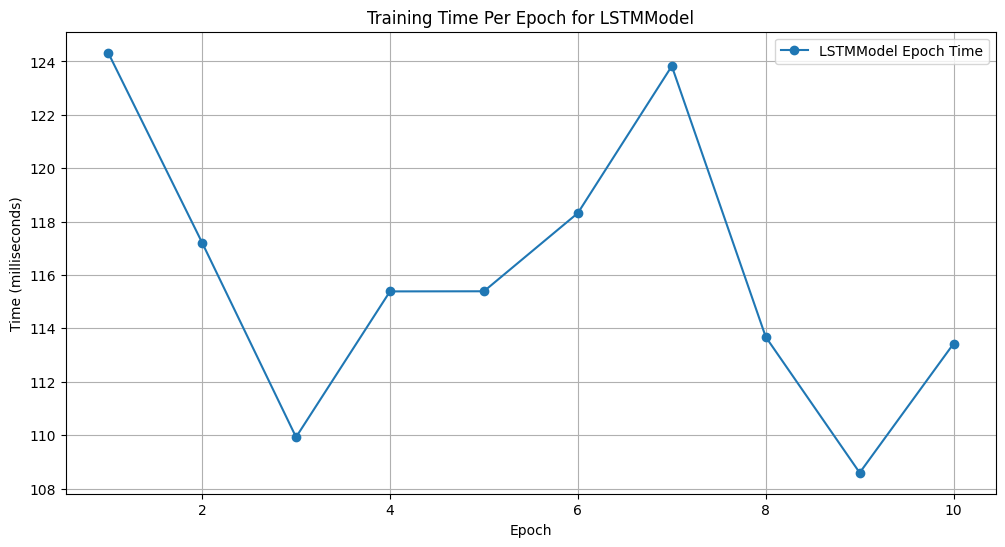

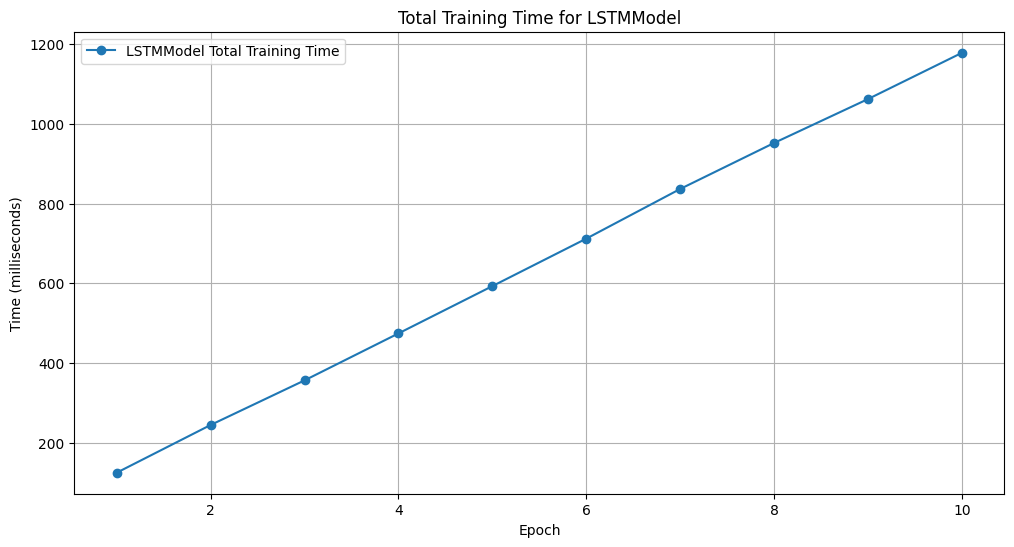

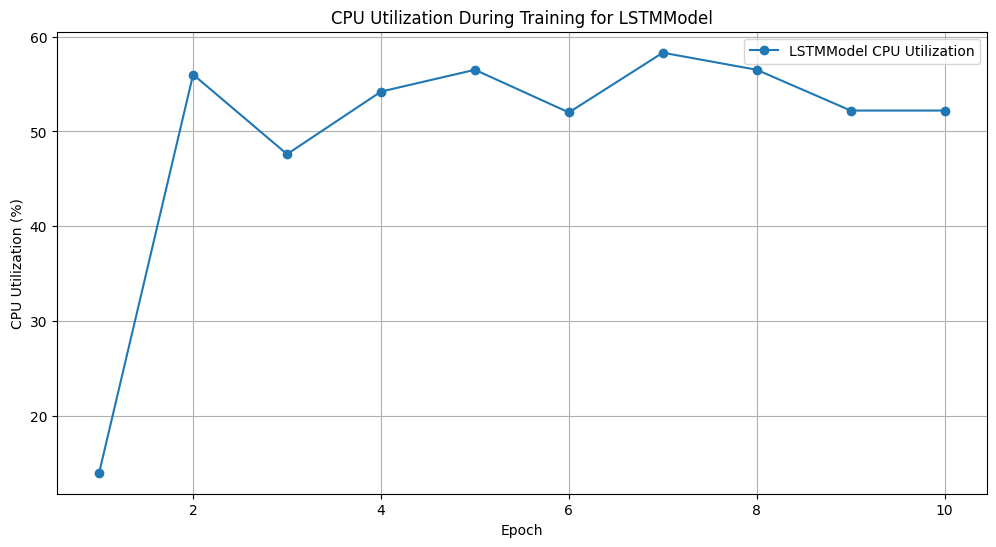

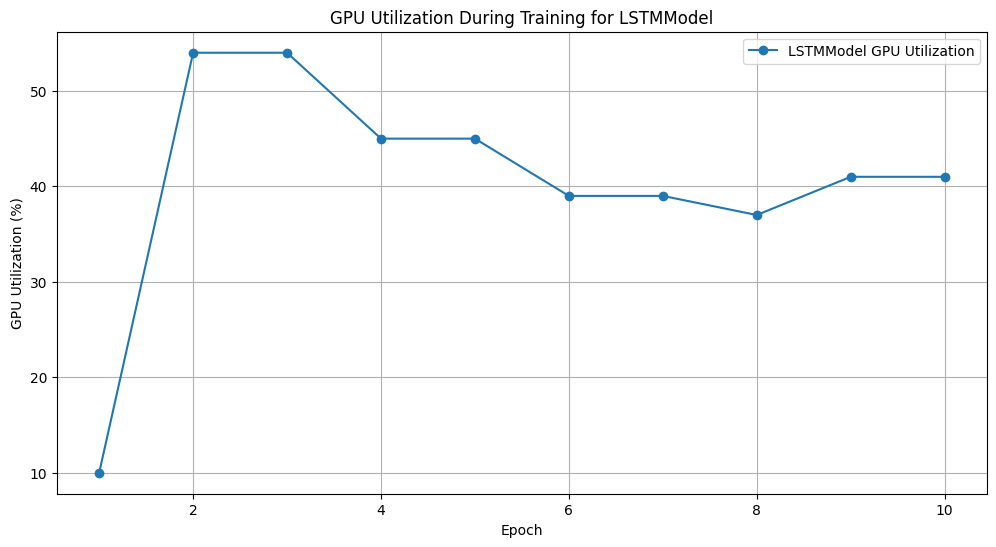

LSTM Test MSE: 0.0376, Test RMSE: 0.1939

Training Mamba Model:
Epoch 1/10, Time: 1066.66 milliseconds
Total Training Time: 1066.66 milliseconds
CPU Utilization (%): 94.6
GPU Utilization (%): 64
Epoch 2/10, Time: 897.64 milliseconds
Total Training Time: 1966.42 milliseconds
CPU Utilization (%): 54.5
GPU Utilization (%): 98
Epoch 3/10, Time: 902.94 milliseconds
Total Training Time: 2870.27 milliseconds
CPU Utilization (%): 53.6
GPU Utilization (%): 98
Epoch 4/10, Time: 896.51 milliseconds
Total Training Time: 3767.67 milliseconds
CPU Utilization (%): 51.1
GPU Utilization (%): 98
Epoch 5/10, Time: 895.80 milliseconds
Total Training Time: 4665.08 milliseconds
CPU Utilization (%): 53.4
GPU Utilization (%): 98
Epoch 6/10, Time: 897.07 milliseconds
Total Training Time: 5563.11 milliseconds
CPU Utilization (%): 53.6
GPU Utilization (%): 98
Epoch 7/10, Time: 908.24 milliseconds
Total Training Time: 6474.18 milliseconds
CPU Utilization (%): 82.4
GPU Utilization (%): 97
Epoch 8/10, Time: 914.17 

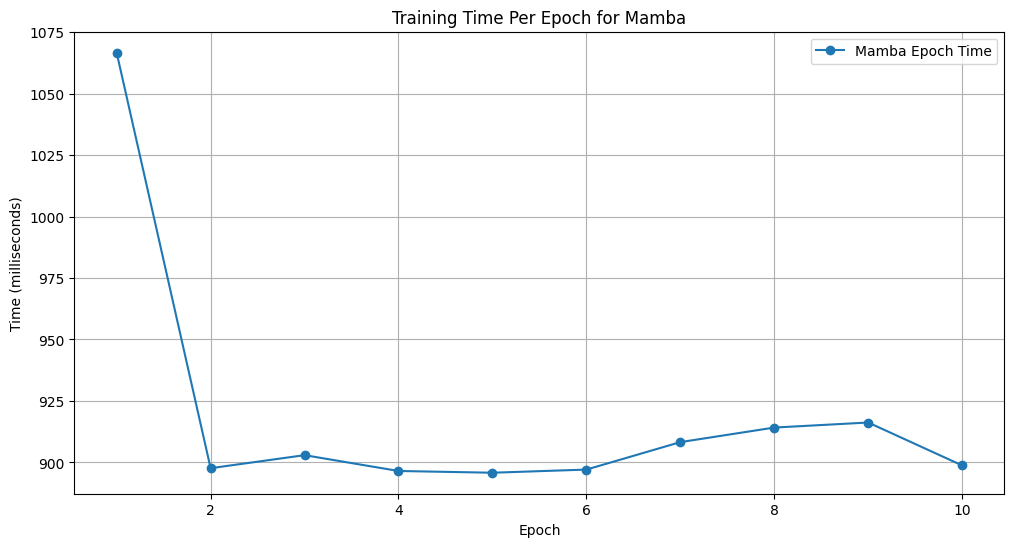

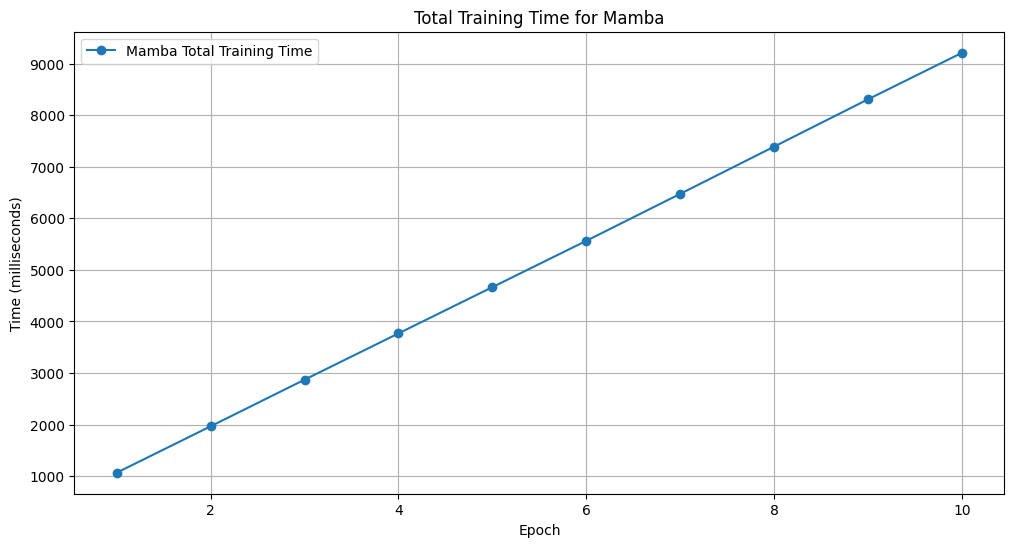

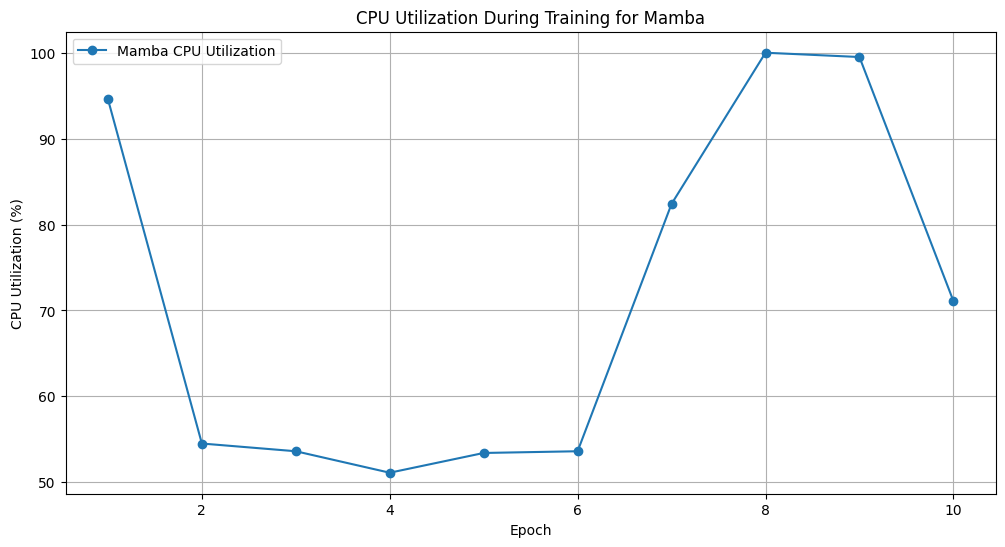

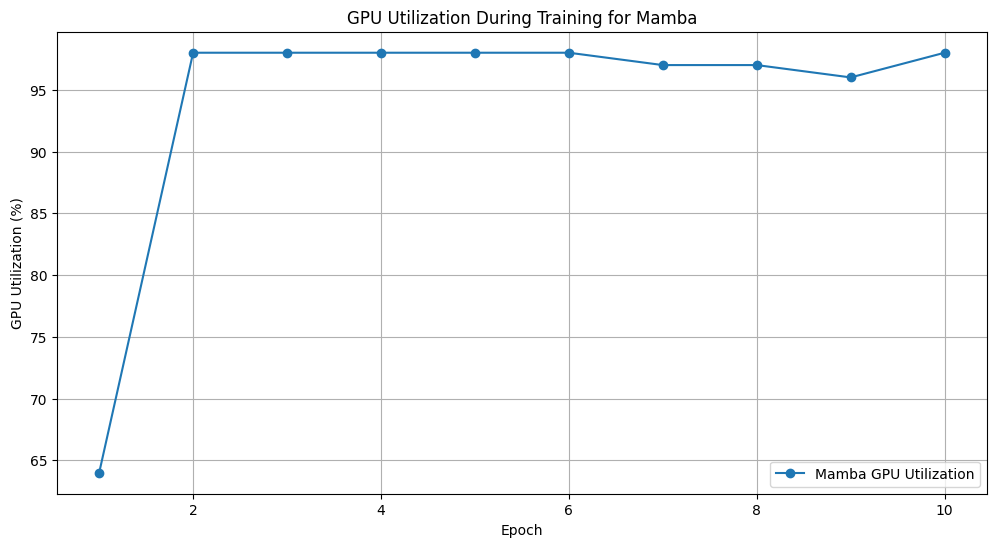

Mamba Test MSE: 0.0010, Test RMSE: 0.0323


In [38]:
def train_model(model, criterion, optimizer, train_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    metrics = {
        'epoch_times': [],
        'total_times': [],
        'cpu_utilizations': [],
        'gpu_utilizations': []
    }
    start_time = time.time() * 1000  # Record start time in milliseconds

    for epoch in range(num_epochs):
        epoch_start_time = time.time() * 1000  # Record start time for epoch in milliseconds
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        epoch_time = (time.time() * 1000) - epoch_start_time  # Calculate epoch time in milliseconds
        total_time = (time.time() * 1000) - start_time  # Calculate total training time in milliseconds

        # Record metrics
        metrics['epoch_times'].append(epoch_time)
        metrics['total_times'].append(total_time)
        metrics['cpu_utilizations'].append(cpu_utilization())

        # GPU utilization
        gpu_info = gpu_info_colab()
        if gpu_info is not None:
            gpu_util, _ = gpu_info  # Only interested in GPU Utilization
            metrics['gpu_utilizations'].append(gpu_util)
        else:
            metrics['gpu_utilizations'].append(0)

        # Print metrics
        print(f"Epoch {epoch + 1}/{num_epochs}, Time: {epoch_time:.2f} milliseconds")
        print(f"Total Training Time: {total_time:.2f} milliseconds")
        print("CPU Utilization (%):", metrics['cpu_utilizations'][-1])
        print("GPU Utilization (%):", metrics['gpu_utilizations'][-1])

    plot_metrics(metrics, model.__class__.__name__)
    return metrics

def cpu_utilization():
    return psutil.cpu_percent()

def gpu_info_colab():
    try:
        pynvml.nvmlInit()
        handle = pynvml.nvmlDeviceGetHandleByIndex(0)
        utilization = pynvml.nvmlDeviceGetUtilizationRates(handle)
        gpu_util = utilization.gpu
        pynvml.nvmlShutdown()
        return gpu_util, None
    except Exception as e:
        print("Error fetching GPU information:", e)
        return None

def plot_metrics(metrics, model_name):
    epochs = list(range(1, len(metrics['epoch_times']) + 1))

    # Plot epoch times
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics['epoch_times'], label=f'{model_name} Epoch Time', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Time (milliseconds)')
    plt.title(f'Training Time Per Epoch for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot total training time
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics['total_times'], label=f'{model_name} Total Training Time', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Time (milliseconds)')
    plt.title(f'Total Training Time for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot CPU utilization
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics['cpu_utilizations'], label=f'{model_name} CPU Utilization', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('CPU Utilization (%)')
    plt.title(f'CPU Utilization During Training for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot GPU utilization
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, metrics['gpu_utilizations'], label=f'{model_name} GPU Utilization', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('GPU Utilization (%)')
    plt.title(f'GPU Utilization During Training for {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_model(model, criterion, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            all_predictions.extend(outputs.tolist())
            all_targets.extend(batch_y.tolist())
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = math.sqrt(mse)
    return mse, rmse

# Create DataLoader for test set
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define device based on availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
lstm_model = LSTMModel().to(device)
mamba_model = Mamba(config).to(device)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)
optimizer_mamba = optim.Adam(mamba_model.parameters(), lr=0.001)

# Train and evaluate LSTM model
print("Training LSTM Model:")
lstm_metrics = train_model(lstm_model, criterion, optimizer_lstm, train_loader)
lstm_mse, lstm_rmse = evaluate_model(lstm_model, criterion, test_loader)
print(f"LSTM Test MSE: {lstm_mse:.4f}, Test RMSE: {lstm_rmse:.4f}")

# Train and evaluate Mamba model
print("\nTraining Mamba Model:")
mamba_metrics = train_model(mamba_model, criterion, optimizer_mamba, train_loader)
mamba_mse, mamba_rmse = evaluate_model(mamba_model, criterion, test_loader)
print(f"Mamba Test MSE: {mamba_mse:.4f}, Test RMSE: {mamba_rmse:.4f}")